In [84]:
def extract_loc_ts_from_gpx(gpx_file_path):
    import xmltodict
    with open(gpx_file_path) as f:
        doc = xmltodict.parse(f.read())['gpx']['trk']
        raw_path = doc['link']['@href']
        vid_name = raw_path[raw_path.rfind('\\')+1:]

        locations = []
        tss = []
        for seg in doc['trkseg']['trkpt']:
            lat = float(seg['@lat'])
            lon = float(seg['@lon'])
            loc = (lon,lat)
            ts = seg['time']
            locations.append(loc)
            tss.append(ts)
        # TODO: what does this length means
        length = doc['extensions']['gpxtrkx:TrackStatsExtension']['gpxtrkx:TotalElapsedTime']
    return locations, tss

gpx_file = 'Sample Data/Track_2015-10-15 060649.gpx'

locations, tss = extract_loc_ts_from_gpx(gpx_file)

new_gps_nts, confidences_nts = snap2road(locations,return_confidence=True)
new_gps = snap2road(locations, tss)

In [1]:
import mapbox as mp
import pandas as pd
import geopandas as gp
import math
import time
from shapely.geometry import Point, LineString
%matplotlib inline

In [66]:
from qgrid import show_grid

In [2]:
def even_chunks(array, max_chunk_size, indices=False):
    import math
    size = len(array)
    num_chunks = math.ceil(size*1.0/max_chunk_size)
    new_chunk_size = int(math.ceil(size*1.0 / num_chunks))
    return chunks(array, new_chunk_size,indices)

def chunks(array, chunk_size, indices=False):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(array), chunk_size):
        if indices:
            yield (i, i + chunk_size)
        else:
            yield array[i:i + chunk_size]

In [3]:
def snap2road(pts_lon_lat, timestamps=[], return_confidence=False):
    """
    params:
        pts_lon_lat: [[lon, lat], [], ...]
        timestamps: ['2015-10-15T12:06:50Z', ...]
    return: 
        new_gps: [[lon, lat], [], ...], len(new_gps) not necessarily equals to len(pts_lon_lat)
        confidences: [ (which batch, # origin pts, # snapped pts, confidence), (), ..]
    """
    import mapbox as mp
    access = "pk.eyJ1Ijoic3VyYWpuYWlyIiwiYSI6ImNpdWoyZGQzYjAwMXkyb285b2Q5NmV6amEifQ.WBQAX7ur2T3kOLyi11Nybw"
    service = mp.MapMatcher(access_token=access)
    new_gps = []
    confidences = []
    for num_batch, (s, e) in enumerate(even_chunks(pts_lon_lat, 100, indices=True)):
        batch_pts = pts_lon_lat[s:e]
        batch_tss = timestamps[s:e]
        geojson = {'type': 'Feature',
                   'properties': {'coordTimes': batch_tss},
                   'geometry': {'type': 'LineString',
                                'coordinates': batch_pts}}
        response = service.match(geojson, profile='mapbox.cycling')
        var = response.geojson()
        features = var['features']
        for f in features:
            coords = f['geometry']['coordinates']
            new_gps.extend(coords)
            properties = f['properties']
            if return_confidence:
                confidences.append((num_batch, len(batch_pts), len(coords), properties['confidence']))
    if return_confidence:
        return new_gps, confidences
    return new_gps

In [4]:

import geom_helper; reload(geom_helper)
from geom_helper import pts2segs

In [5]:
segs_dc = gp.read_file(u'd:\\★★学习工作\\Life in Maryland\\Research Project：CyclingSafe\\Cycling_safety\\open_data_analysis\\data\\segments_dc.geojson')

### note for def seg_disambiguation:
1. if the first/last point of trace is on segmentA, but the rest are on segmentB, then the first point would be mistakenly assigned to segmentB. E.g. test_pts2segs3.geojson; 
    - solution: increase weights(multiple by window_size) to self seg_cands
        - Problem: window_size weights cause jump (test_pts2segs3[22:27])
            - solution: seconde phrase clean use a decrease weight factor=0.5
                - problem: still have jump (test_pts2segs3[22:26])
    - solution2: assign self seg_cands' weight with: window_size * 2 - len(context_left) - len(context_right) + 1
        - Problem: not good enough (test_pts2segs3[22:26] still jump)
            - enhance solution: use clean seg as left context
                - Problem: every point at intersection will be shifted to previous segment(especially when the last points are at intersection)            
2. timestamps helps: test_pts2segs5 is messy without timestamps.
3. random choice of tie seg isn't a good idea, because it's not garunteed that tie segs are one of the turning segs. e.g. test_pts2segs5 snapped.loc[137]
    - Solution: keep tie for the 1st phrase clean up --> it also solve the problem of intersection shifted
        - exception: test_pts2segs5 snapped.loc[83:87], because the orgn pts is messy

In [110]:
def seg_disambiguation(list_of_seg_candidates, window_size=3, debug=False, decrease_weight=0.0, keep_tie=False):
    from itertools import chain
    from collections import Counter
    def debug_tie_count():
        max_count = counter.most_common(1)[0][1]
        tie_node = []
        for node, count in counter.most_common():
            if count>=max_count:
                tie_node.append(node)
        tie_count = len(tie_node)
        if tie_count==2: print i, counter
        assert tie_count<=3, ('index=',i, 'context_counter=', counter)
    
    def get_tie():
        max_count = counter.most_common(1)[0][1]
        tie_node = []
        for node, count in counter.most_common():
            if count>=max_count:
                tie_node.append(node)
        return tie_node
    
    clean_segs = []
    list_size = len(list_of_seg_candidates)
    for i, seg_cands in enumerate(list_of_seg_candidates):
        left, right = max(0, i-window_size), min(list_size, i+window_size+1)
        context_left = clean_segs[left: i]  # use clean seg instead of original seg_candidates
        context_right = list_of_seg_candidates[i+1: right]
        counter_left = Counter(list(chain(*context_left)))
        counter_right = Counter(list(chain(*context_right)))
#         counter_self = Counter(seg_cands * int(window_size * (1-decrease_weight)))  # solution1, doesn't work well
        counter_self = Counter(seg_cands * (window_size * 2 - len(context_left) - len(context_right) + 1))
        counter = counter_left + counter_right + counter_self
        tie = get_tie()
        if keep_tie:
            seg = tie  # keep all tie
        else:
            seg = [tie[0]]  # keep the first element of tie
        clean_segs.append(seg)
        if debug:
            debug_tie_count()
    return clean_segs
#         print counter_left.most_common(1),counter_right.most_common(1),counter.most_common(1)

In [ ]:
def trace2segs(trace_pts, segs, tss=[], return_confidence=False, close_jn_dist=10, far_jn_dist=30):
    pts_lon_lat = list(orgn_pts.geometry.apply(lambda x: x.coords[0]).values)
    snap_pts = snap2road(pts_lon_lat,tss, return_confidence=return_confidence)

    if return_confidence:  # if return_confidence
        snap_pts, confs = snap_pts   

    snap_pts_gpdf = gp.GeoDataFrame([Point(x) for x in snap_pts],columns=['geometry'])
    print snap_pts_gpdf.shape, confs

    pts_segs, _ = pts2segs(snap_pts_gpdf, segs, bfr_crs=3559, close_jn_dist, far_jn_dist)

    snap_pts_gpdf = snap_pts_gpdf.merge(
        snap_pts_gpdf.merge(pts_segs, left_index=True, right_on='index_pt').groupby('index_pt')['index_ln'].apply(list).to_frame(), 
        left_index=True, right_index=True)
    snap_pts_gpdf['clean_seg']=seg_disambiguation(snap_pts_gpdf.index_ln.values,keep_tie=True)

    snap_pts_gpdf['clean_seg2']=seg_disambiguation(snap_pts_gpdf.clean_seg.values)

(204, 1)
(307, 1) [(0, 68, 116, 0.8553247543617214), (1, 68, 100, 0.919279313449731), (2, 68, 91, 0.6664026680287239)]


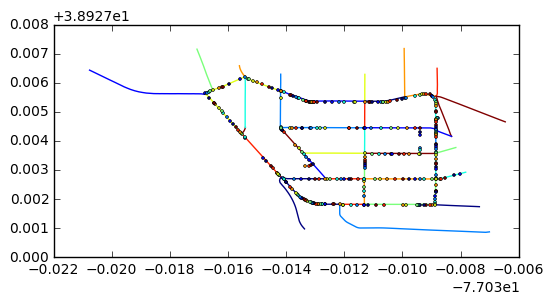

In [100]:
orgn_pts = gp.read_file('test_pts2segs5.geojson')
tss = [time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(t+i*5)) for i in range(orgn_pts.shape[0])]
print orgn_pts.shape

return_confidence=True
pts_lon_lat = list(orgn_pts.geometry.apply(lambda x: x.coords[0]).values)

snap_pts = snap2road(pts_lon_lat,tss, return_confidence=return_confidence)

if return_confidence:  # if return_confidence
    snap_pts, confs = snap_pts   
    
snap_pts_gpdf = gp.GeoDataFrame([Point(x) for x in snap_pts],columns=['geometry'])
print snap_pts_gpdf.shape, confs

pts_segs, _ = pts2segs(snap_pts_gpdf, segs_dc, bfr_crs=3559, close_jn_dist=10, far_jn_dist=30)

snap_pts_gpdf = snap_pts_gpdf.merge(
    snap_pts_gpdf.merge(pts_segs, left_index=True, right_on='index_pt').groupby('index_pt')['index_ln'].apply(list).to_frame(), 
    left_index=True, right_index=True)

segs_dc.loc[pts_segs.index_ln.value_counts().index.tolist()][['geometry']].append(snap_pts_gpdf).plot()

In [113]:
snap_pts_gpdf['clean_seg']=seg_disambiguation(snap_pts_gpdf.index_ln.values,keep_tie=True)

snap_pts_gpdf['clean_seg2']=seg_disambiguation(snap_pts_gpdf.clean_seg.values)

show_grid(pd.DataFrame(snap_pts_gpdf.iloc[:,1:]))

5 Counter({2432: 4, 2431: 4, 2220: 1})
37 Counter({2432: 4, 2025: 4, 2024: 1, 2134: 1})
50 Counter({2025: 4, 2026: 4, 7903: 1})
64 Counter({2026: 4, 2191: 4, 4804: 2, 2190: 2, 2192: 1})
66 Counter({2190: 4, 2191: 4, 2026: 2, 4804: 2})
73 Counter({5257: 4, 2190: 4, 7904: 2, 5258: 1})
86 Counter({5257: 4, 5084: 4, 1051: 1, 1052: 1})
113 Counter({5083: 4, 5084: 4, 1129: 1, 1130: 1})
127 Counter({5082: 4, 5083: 4, 5112: 1})
137 Counter({935: 5, 5111: 5, 5082: 3})
155 Counter({935: 4, 934: 4, 2383: 2, 2384: 1})
166 Counter({933: 4, 934: 4, 2136: 1, 2135: 1})
175 Counter({932: 4, 933: 4, 2132: 1, 2131: 1})
184 Counter({932: 4, 2430: 4, 2429: 1})
198 Counter({2430: 4, 1126: 4, 2431: 1})
203 Counter({2133: 4, 1126: 4, 2132: 1, 1127: 1})
212 Counter({2133: 4, 2134: 4, 1175: 1})
220 Counter({2134: 3, 1175: 3, 2025: 1})
228 Counter({1050: 4, 1175: 4, 2137: 1})
237 Counter({2385: 4, 1050: 4, 1051: 1})
252 Counter({2384: 4, 2385: 4, 1128: 1, 1129: 1})
274 Counter({2136: 4, 1127: 4, 2137: 1, 1128: 1

In [115]:
part_segs_dc_plt= segs_dc.loc[pts_segs.index_ln.value_counts().index.tolist()][['geometry']].reset_index()
part_segs_dc_plt['color']='#0a0'

snap_line = gp.GeoDataFrame([LineString(snap_pts_gpdf.geometry.tolist())], columns=['geometry'])
snap_line['color'] = '#aa0'

snap_pts_gpdf_plt = snap_pts_gpdf.reset_index()
snap_pts_gpdf_plt['wkt'] = snap_pts_gpdf_plt.geometry.apply(lambda x: x.wkt)
snap_pts_gpdf_plt.index_ln = snap_pts_gpdf_plt.index_ln.apply(str)
snap_pts_gpdf_plt.clean_seg = snap_pts_gpdf_plt.clean_seg.apply(str)
snap_pts_gpdf_plt.clean_seg2 = snap_pts_gpdf_plt.clean_seg2.apply(str)
snap_pts_gpdf_plt.geometry = snap_pts_gpdf_plt.buffer(0.00002)
snap_pts_gpdf_plt['color'] = '#a00'

orgn_pts_plt = orgn_pts.reset_index()
orgn_pts_plt['wkt'] = orgn_pts_plt.geometry.apply(lambda x: x.wkt)
orgn_pts_plt.geometry = orgn_pts_plt.buffer(0.00002)
orgn_pts_plt['color'] = '#00a'

from leaflet_creation import create_map_visualization

html_title = 'openstreetmap elements'
file_path = ''
file_name = 'vis snap2segs'
lon, lat = -77.0908494, 38.9045525  #D.C.
zoom = 12
init_layers = ['streets', 'stsg']
map_layers = ['light','streets', 'satellite']
binding_data=[['ly1','snap'],['ly2','orgn'],['ly3', 'segments'],['ly4','snap line']]
gpdfs = [snap_pts_gpdf_plt, orgn_pts_plt, part_segs_dc_plt, snap_line]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

,geometry
0,"LINESTRING (-77.041314 38.928815, -77.041572 3..."


In [109]:
for i in range(1,2):
    i+=1
    data = gp.read_file('test_pts2segs{}.geojson'.format(i))
    gps = data.geometry.apply(lambda x: x.coords[0]).values
    gps_snap, conf = snap2road(list(gps))
    print conf, len(gps_snap)
    gps_snap_gpdf = gp.GeoDataFrame([Point(x) for x in gps_snap],columns=['geometry'])
#     gps_snap_gpdf.geometry = gps_snap_gpdf.buffer(0.00005)
#     gps_snap_gpdf.plot()
#     gps_snap_gpdf.append(data[:100]).plot(figsize=(15,15))

[(0, 51, 77, 0.2694488616952322)] 77


In [82]:
list_gps = []
for i in range(6):
    i+=1
    data = gp.read_file('test_pts2segs{}.geojson'.format(i))
    gps = data.geometry.apply(lambda x: x.coords[0]).tolist()
    list_gps.append(gps)

In [84]:
import datetime

In [100]:
import time
def work_every_sec(sec=1):
    sec = float(sec)
    stop = sec - time.time() % sec
    if stop>0.20:
        time.sleep(stop)
    else:
        time.sleep(0.20)

In [101]:
sleep = True

sd = datetime.datetime.now()
for i in range(200):
    ix = i % 6
    gps = list_gps[ix]
    gps_snap = snap2road(gps)
    if sleep:
        work_every_sec()
    if i % 20 == 0:
        print 'processed', i+1

ed = datetime.datetime.now()
print sd
print ed
print ed-sd
print (ed-sd).seconds

processed 1
processed 21
processed 41
processed 61
processed 81
processed 101
processed 121
processed 141
processed 161
processed 181
2017-02-07 15:34:54.636000
2017-02-07 15:38:16
0:03:21.364000
201


In [123]:
gps_snap2

([[[-77.039973, 38.903739],
   [-77.039931, 38.903739],
   [-77.039879, 38.903739],
   [-77.039801, 38.903739],
   [-77.039748, 38.903739],
   [-77.039662, 38.903739],
   [-77.039568, 38.903739],
   [-77.0395, 38.903739],
   [-77.039414, 38.90374],
   [-77.039407, 38.903739],
   [-77.039329, 38.90374],
   [-77.039299, 38.90374],
   [-77.03924, 38.90374],
   [-77.039168, 38.90374],
   [-77.039095, 38.90374],
   [-77.039036, 38.903741],
   [-77.039023, 38.903741],
   [-77.038898, 38.903741],
   [-77.038949, 38.903741],
   [-77.038777, 38.903741],
   [-77.038744, 38.903741],
   [-77.038647, 38.903741],
   [-77.038589, 38.903741],
   [-77.038562, 38.903741],
   [-77.038519, 38.903741],
   [-77.038515, 38.903742],
   [-77.038515, 38.903741],
   [-77.038515, 38.903778],
   [-77.038514, 38.903785],
   [-77.038514, 38.903844],
   [-77.038514, 38.903893],
   [-77.038514, 38.903975],
   [-77.038513, 38.904079],
   [-77.038513, 38.904135],
   [-77.038513, 38.904212],
   [-77.038513, 38.904257],
 

In [118]:
features = gps_snap2['features']
assert len(features)==1, 'multiple features suggest poor snap to road quality'
properties = features[0]['properties']
confidence = properties['confidence']
duration = properties['duration']
confidence, duration

(0.8744916679690088, 267.8)

In [112]:
gps_snap2

{u'code': u'Ok',
 u'features': [{u'geometry': {u'coordinates': [[-77.044189, 38.932807],
     [-77.044187, 38.932915],
     [-77.044186, 38.933007],
     [-77.044186, 38.933148],
     [-77.044186, 38.933184],
     [-77.044187, 38.933291],
     [-77.044187, 38.933357],
     [-77.044187, 38.933574],
     [-77.044187, 38.933674],
     [-77.044187, 38.933733],
     [-77.044187, 38.933803],
     [-77.044187, 38.93382],
     [-77.044187, 38.933903],
     [-77.044188, 38.933992],
     [-77.044188, 38.934126],
     [-77.044189, 38.934174],
     [-77.044188, 38.934262],
     [-77.044188, 38.934284],
     [-77.044185, 38.934332],
     [-77.044178, 38.93438],
     [-77.044164, 38.934429],
     [-77.044159, 38.934452],
     [-77.044142, 38.934498],
     [-77.044136, 38.934509],
     [-77.044105, 38.934573],
     [-77.044076, 38.934621],
     [-77.044052, 38.934653],
     [-77.044051, 38.934654],
     [-77.044026, 38.934691],
     [-77.043989, 38.934736],
     [-77.043954, 38.934776],
     [-77.043

In [109]:
try:
    assert 1!=1, 'assertion error'
except AssertionError as e:
    print e

assertion error
